## Wordcloud of top words from tweets

The following script finds the most frequent words in a set of tweets and creates a wordcloud of those words. The more often a term is used, the larger the word is in the wordcloud. Many times wordcloud analyses are used to see word frequencies in relation to eachother, but this particular script strips out stopwords so the resulting words shed light on recuring themes.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (RED)](https://kb.iu.edu/d/apum). You will also need to have access to RED through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up RED, and how to get started using the Jupyter Notebook on RED.   

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In your terminal, packages can be installed by simply typing "pip install nameofpackage --user" (minus the quotes). 


- **nltk:** Platform for building Python programs to work with human language data.

- **os:** This module provides a portable way of using operating system dependent functionality.

- **string:** contains a number of useful constants and classes, as well as some deprecated legacy functions that are also available as methods on strings.

- **collections:** Implements specialized container datatypes providing alternatives to Python's general purpose built-in containers: dict, list, set, and tuple.

- **wordcloud:** A simple wordcloud generator in Python.

- **PIL:** Stands for Python Imaging Library and adds image processing capabilities.

- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

- **numpy:** The fundamental package for scientific computing with Python.

- **re:** Provides regular expression matching operations similar to those found in Perl.

- **operator:** Exports a set of functions corresponding to the intrinsic operators of Python.

- **csv:** Implements classes to read and write tabular data in CSV format.

In [1]:
from nltk.corpus import stopwords
import os
import string
from collections import defaultdict
import wordcloud
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import re
import operator
import csv

### Stopwords
Here we save the nltk stopwords list as the variable 'stop_words' (minus the quotes). If you need a different language, simply change 'english' (keep the quotes) to the anglicized name of the language you wish to use (e.g. 'spanish' instead of 'espanol' or 'german' instead of 'deutsch'). If you wish to add additional words to the stop_words variable, add the word in quotes to the list in stop_words.extend(['the', 'words', 'you', 'want', 'to', 'add']). 

In [2]:
stop_words = stopwords.words('english')
stop_words.extend(['amp','rt', 'xo_karmin_ox', 'neveragain', 'ð', 'â', 'ï', 'emma4change'])

### Functions
We need to create a few functions in order to calculate and create a wordcloud. Any time you see 'def' (without the quotes) that means we are DEclaring a Function. The 'def' is usually followed by the name of the function being created and then in parentheses are the arguments the function requires. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed or in other words what the function is doing. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required arguments in the parentheses. This allows you to do what the function does without having to write out all the code in the function every time you wish to perform that task.

#### Text Cleaning
The first function does some text cleaning for us and requires the text being cleaned and whether or not there is a stopword list for arguments. Now come the statements to be executed. First we lowercase the text or else 'Love' and 'love' will be counted as two different words, so we make them all 'love'. Next we remove URLs by removing anything that begins with 'http'. Then we split the tweets into individual words and remove empty spaces. Then we remove any digits, stopwords, and punctuation and return a list of cleaned words.

In [3]:
def textClean(text, stopWordsList = None):
    
    text = text.strip().lower()
    
    tweets = re.sub(r"http\S+", "", text)
    
    tokens = re.split(r'\W+', tweets )
    
    # remove empty string
    tokens = [t for t in tokens if t]
    
    # remove digits
    tokens = [t for t in tokens if not t.isdigit()]
    
    # built-in stop words list
    tokens = [t for t in tokens if t not in stop_words]
    
    # custom stop words list
    if stopWordsList is not None:
        tokens = [t for t in tokens if t not in stopWordsList]
        
    # remove punctuation
    puncts = list(string.punctuation)
    puncts.append('--')

    tokens = [t for t in tokens if t not in puncts]

    return tokens

#### Plot wordcloud

Now we need a function that creates a wordcloud based on word frequency and plots it. To start we name the needed arguments which includes the words, the file path where we want to save the resulting visualization, the dpi quality of the result, the maximum amount of words we want the wordcloud to show, and if we have a special shape we want the wordcloud to take.

The statements to execute begin by determining the word frequency and then what to do regarding the shape of the wordcloud. The wordcloud package uses an image file which is refered to as a mask to determine the shape. Next we need to describe the aesthetics of the wordcloud such as background color, maximum number of words, the mask shape, and color scheme of the wordcloud. We do this using functions and arguments from the wordcloud package and saving them as the variable 'wc' for wordcloud.

Next we need to generate the wordcloud and make sure it is generated using word frequency and displays the words, not the frequency and saves the resulting image as a file. Next are the parameters for how the wordcloud is displayed, so we state the figures size, that we want it to look like what we described in our 'wc' variable above it, that we are not using an x or y axis, and we want the layout to be tight instead of spread out. Then we state arguments for how we want the wordcloud saved to file and finally that we want to see the final result displayed in the notebook.

In [4]:
def plotWordCloud(tokens, wcImgFilepath, dpi,  maxWordCnt, maskFilepath = None):

    freq = defaultdict(int)

    for t in tokens:
        freq[t] += 1
        
    if maskFilepath is not None:
        mask = np.array(Image.open(maskFilepath))
    else:
        mask = None

    wc = wordcloud.WordCloud(background_color = "white", scale=4, colormap='Dark2_r', max_words = maxWordCnt, mask = mask)
    

    # generate word cloud
    wc.fit_words(freq)

    # store to file
    wc.to_file(wcImgFilepath)

    # show
    plt.figure(figsize = (60, 20))
    plt.imshow(wc, interpolation = 'bilinear')
    
    plt.axis("off")

    plt.tight_layout()
    
    # save graph as a png image to file
    plt.savefig(wcImgFilepath, format = 'png', dpi = dpi, bbox_inches = 'tight')
    plt.show()

#### Read a .csv file

This function gives arguments and statements for how to read a .csv file. We are incluidng that we want the reader to encode in utf-8 and ignore any errors from non-utf-8 characters and, therefore, 'ignores' those characters entirely. This is needed for social media due to the use of emojiis and other abnormal characters. Then we tell Python to seperate the lines using a comma as the delimiter. Next we add the lines as rows in a column. Finally, we return the the content starting with row 1, not row 0, as row 0 is the header.  

In [5]:
def readCSV(filepath, textColIndex, encoding = 'utf-8', errors = 'ignore'):
    
    with open(filepath, encoding = encoding, errors = errors) as f:
        
        reader = csv.reader(f, delimiter = ',', quotechar = '"')
        
        content = []
        for row in reader: 
            content.append(row[textColIndex])
         
        # skip header
        return content[1 : ]

#### Pull from a single .csv file

This function reads a single .csv file from which we will be counting and ploting the wordcloud. This function opens the file, reads it, adds the new line mark to the end of each row ('\n'.join(content)), so that the cleaning function we created above knows where the end of each line is. It adds the ability to include an additional stopword list and then calls the wordcloud plotting function we created above.

In [6]:
def drawWordCloudFromSingleCSV(csvFilepath, textColIndex, encoding, errors, 
                               stopWordsList, wcImgFilepath, dpi,  maxWordCnt, maskFilepath = None):
    
    content = readCSV(csvFilepath, textColIndex, encoding, errors)
    
    text = '\n'.join(content)
    
    tokens = textClean(text, stopWordsList)
    
    plotWordCloud(tokens, wcImgFilepath, dpi, maxWordCnt, maskFilepath)
    

#### Pull from a directory

This function reads all .csv files in a directory from which we will be counting and ploting a wordcloud. This function 'walks' through the directory and all sub-directories, ignores hidden files which are designated by the file name beginning with a period. The function then creates a variable that says to include the entire file path for each file in the directory. This function opens the file, reads it, adds the new line mark to the end of each row ('\n'.join(content)), so that the cleaning function we created above knows where the end of each line is, and adds the ability to include an additional stopword list. Then the function says to print the file path as soon as the file has been processed so we can see the progress and finally it calls the wordcloud plotting function we created above.

In [7]:
def drawWordCloudFromScanCSV(csvRoot, textColIndex, encoding, errors, stopWordsList, 
                             wcImgFilepath, dpi,  maxWordCnt, maskFilepath = None):
   
    tokens = []
    
    for root, subdirs, files in os.walk(csvRoot):
        
        for filename in files:
            
            # skip hidden file
            if filename.startswith('.'):
                continue
            
            textFilepath = os.path.join(root, filename)
            
            content = readCSV(textFilepath, textColIndex, encoding, errors)
            text = '\n'.join(content)
            tokens.extend(textClean(text, stopWordsList))
                
            print('Finished tokenizing text {}\n'.format(textFilepath))
    
    plotWordCloud(tokens, wcImgFilepath, dpi, maxWordCnt, maskFilepath)

#### File paths and additional stopwords

Now we need to point to the directories we will be using. This includes a directory that houses a file with additional stopwords to add to the one from the nltk package we used in our cleaning script above. 

This is where you will most likely be making changes. You will need to change the file paths to match the ones on your Carbonate account or computer. The first one 'stopWordsFilepath' we use to point to our additional stopwords file. The second one 'csvRoot' points to the directory where our data file or files are located.

Then we have to point to the additional stopwords file and read it and lowercase all the words in the list and save the final opened and lowercased list of stopwords as a variable to use later.

In [8]:
# load custom stop words list

stopWordsFilepath = '/N/u/klosteda/Carbonate/Text-Analysis/data/earlyModernStopword.txt'

csvRoot = '/N/u/klosteda/Carbonate/Text-AnalysisBox/data/twitter/parkland'

with open(stopWordsFilepath, "r") as f:
    stopWordsList = f.readlines()
            
stopWordsList = [w.strip().lower() for w in stopWordsList]

#### Wordcloud from a single file

The script in the box below now uses the functions and file paths we have created to get word frequencies and plot a wordcloud from a single .csv file containing tweets. We start by pointing to the specific file. Then we say which column we are interested in, what encoding we want, and that we wish to ignore encoding errors (or more accurately, ignore the character causing the error). Next we say where we want the output file saved and what we want to name the file. Then we choose our dpi setting, which you can change to meet your needs. Now we include the file path to the image for our mask. Simply hastag this line out if you do not want to use a mask and add '= None' to the maskFilepath argument in the 'drawWordCloudFromSingleCSV' function below. Then we choose our maximum word count. Right now it is set to show the 300 most frequently used words. Then we implement the single text plotting function we created above to give us a wordcloud of most frequent thematic words from our tweets.

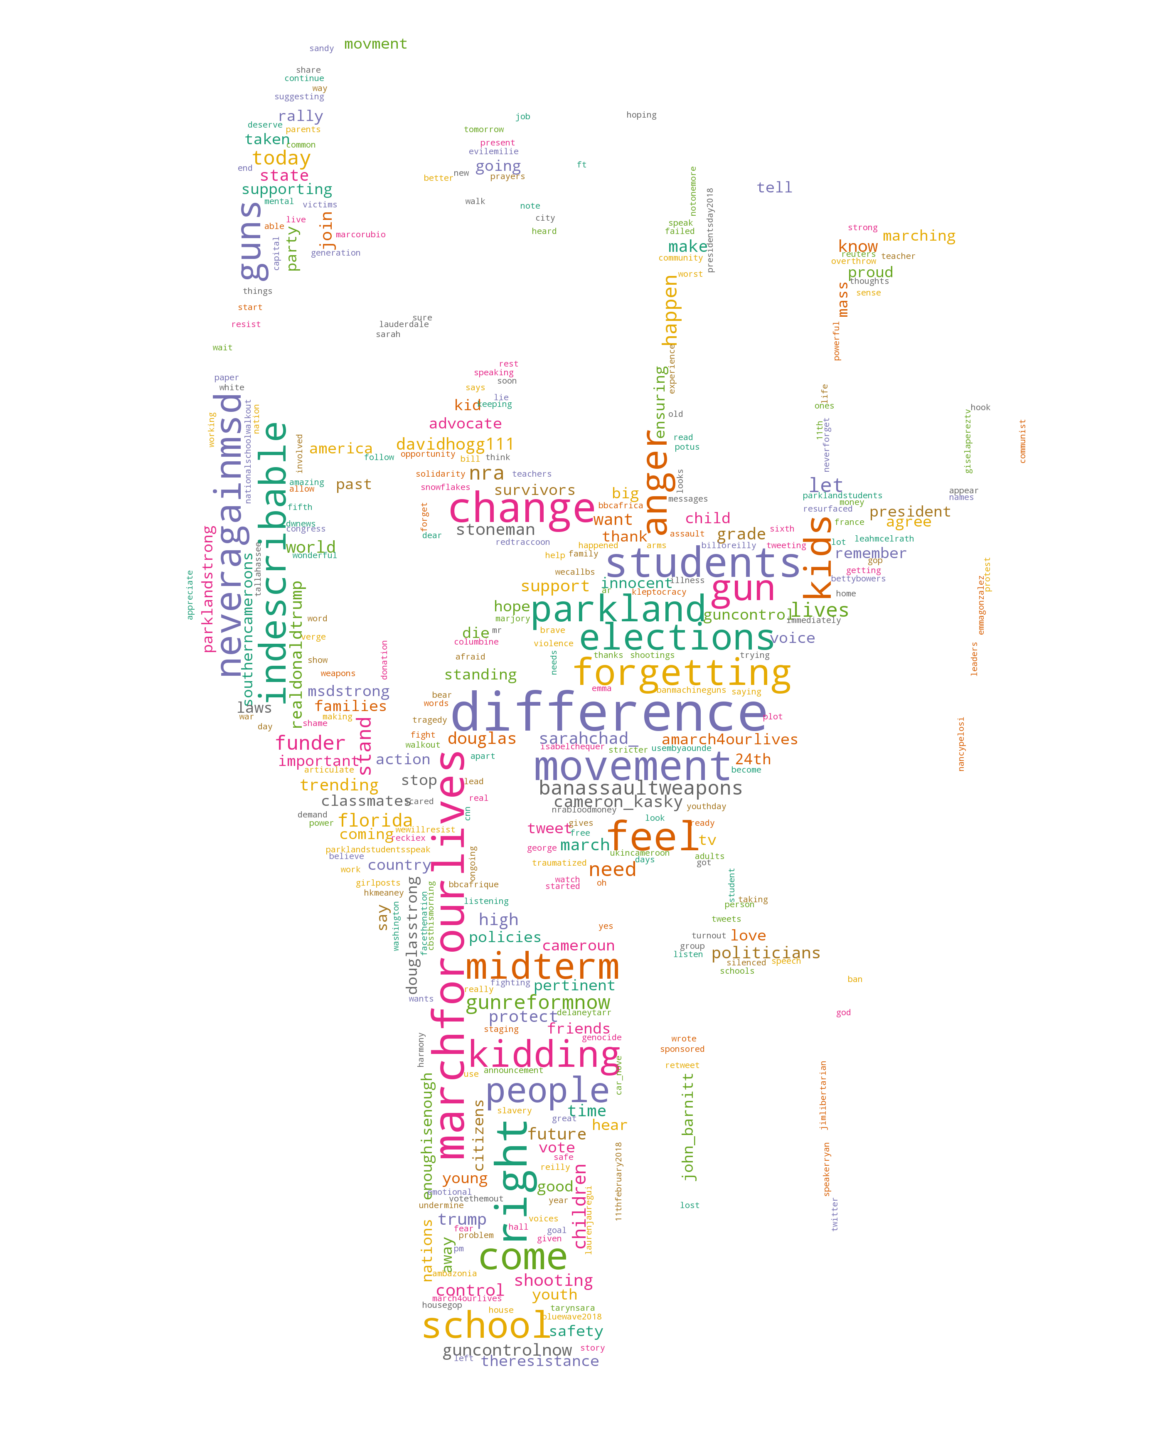

In [9]:
# Use case one, draw word cloud from a single tweet csv

csvFilepath = os.path.join(csvRoot,'neverAgain.csv')

textColIndex = 2

encoding = 'utf-8'

errors = 'ignore'

wcImgFilepath = '/N/u/klosteda/Carbonate/Text-Analysis/Output/wordcloudTwitterNeverAgain.png'

dpi = 300

# As an option, user can provision a mask related to the text theme
maskFilepath = '/N/u/klosteda/Carbonate/Text-Analysis/data/wordcloudMasks/Fist.png'

maxWordCnt = 500

drawWordCloudFromSingleCSV(csvFilepath, textColIndex, encoding, errors, 
                               stopWordsList, wcImgFilepath, dpi, maxWordCnt, maskFilepath)

#### Wordcloud from multiple files in a directory

The script in the box below now uses the functions and file paths we have created above to get word frequencies and plot a wordcloud from multiple .csv files containing tweets in a directory. We start by saying which column we are interested in, what encoding we want, and that we wish to ignore encoding errors (or more accurately, ignore the character causing the error). Next we say where we want the output file saved and what we want to name that file. Then we choose our dpi setting, which you can change to meet your needs. Now we include the file path to the image for our mask. Simply hastag this line out if you do not want to use a mask and add '= None' to the maskFilepath argument in the 'drawWordCloudFromScan' function below. Then we choose our maximum word count. Right now it is set to show the 100 most frequently used words. Then we implement the directory scan plotting function we created above to give us a wordcloud of most frequent thematic words from our collection of .csv files containing tweets.

Finished tokenizing text /N/u/klosteda/Carbonate/Text-AnalysisBox/data/twitter/parkland/neverAgain.csv

Finished tokenizing text /N/u/klosteda/Carbonate/Text-AnalysisBox/data/twitter/parkland/nra.csv

Finished tokenizing text /N/u/klosteda/Carbonate/Text-AnalysisBox/data/twitter/parkland/parkland.csv



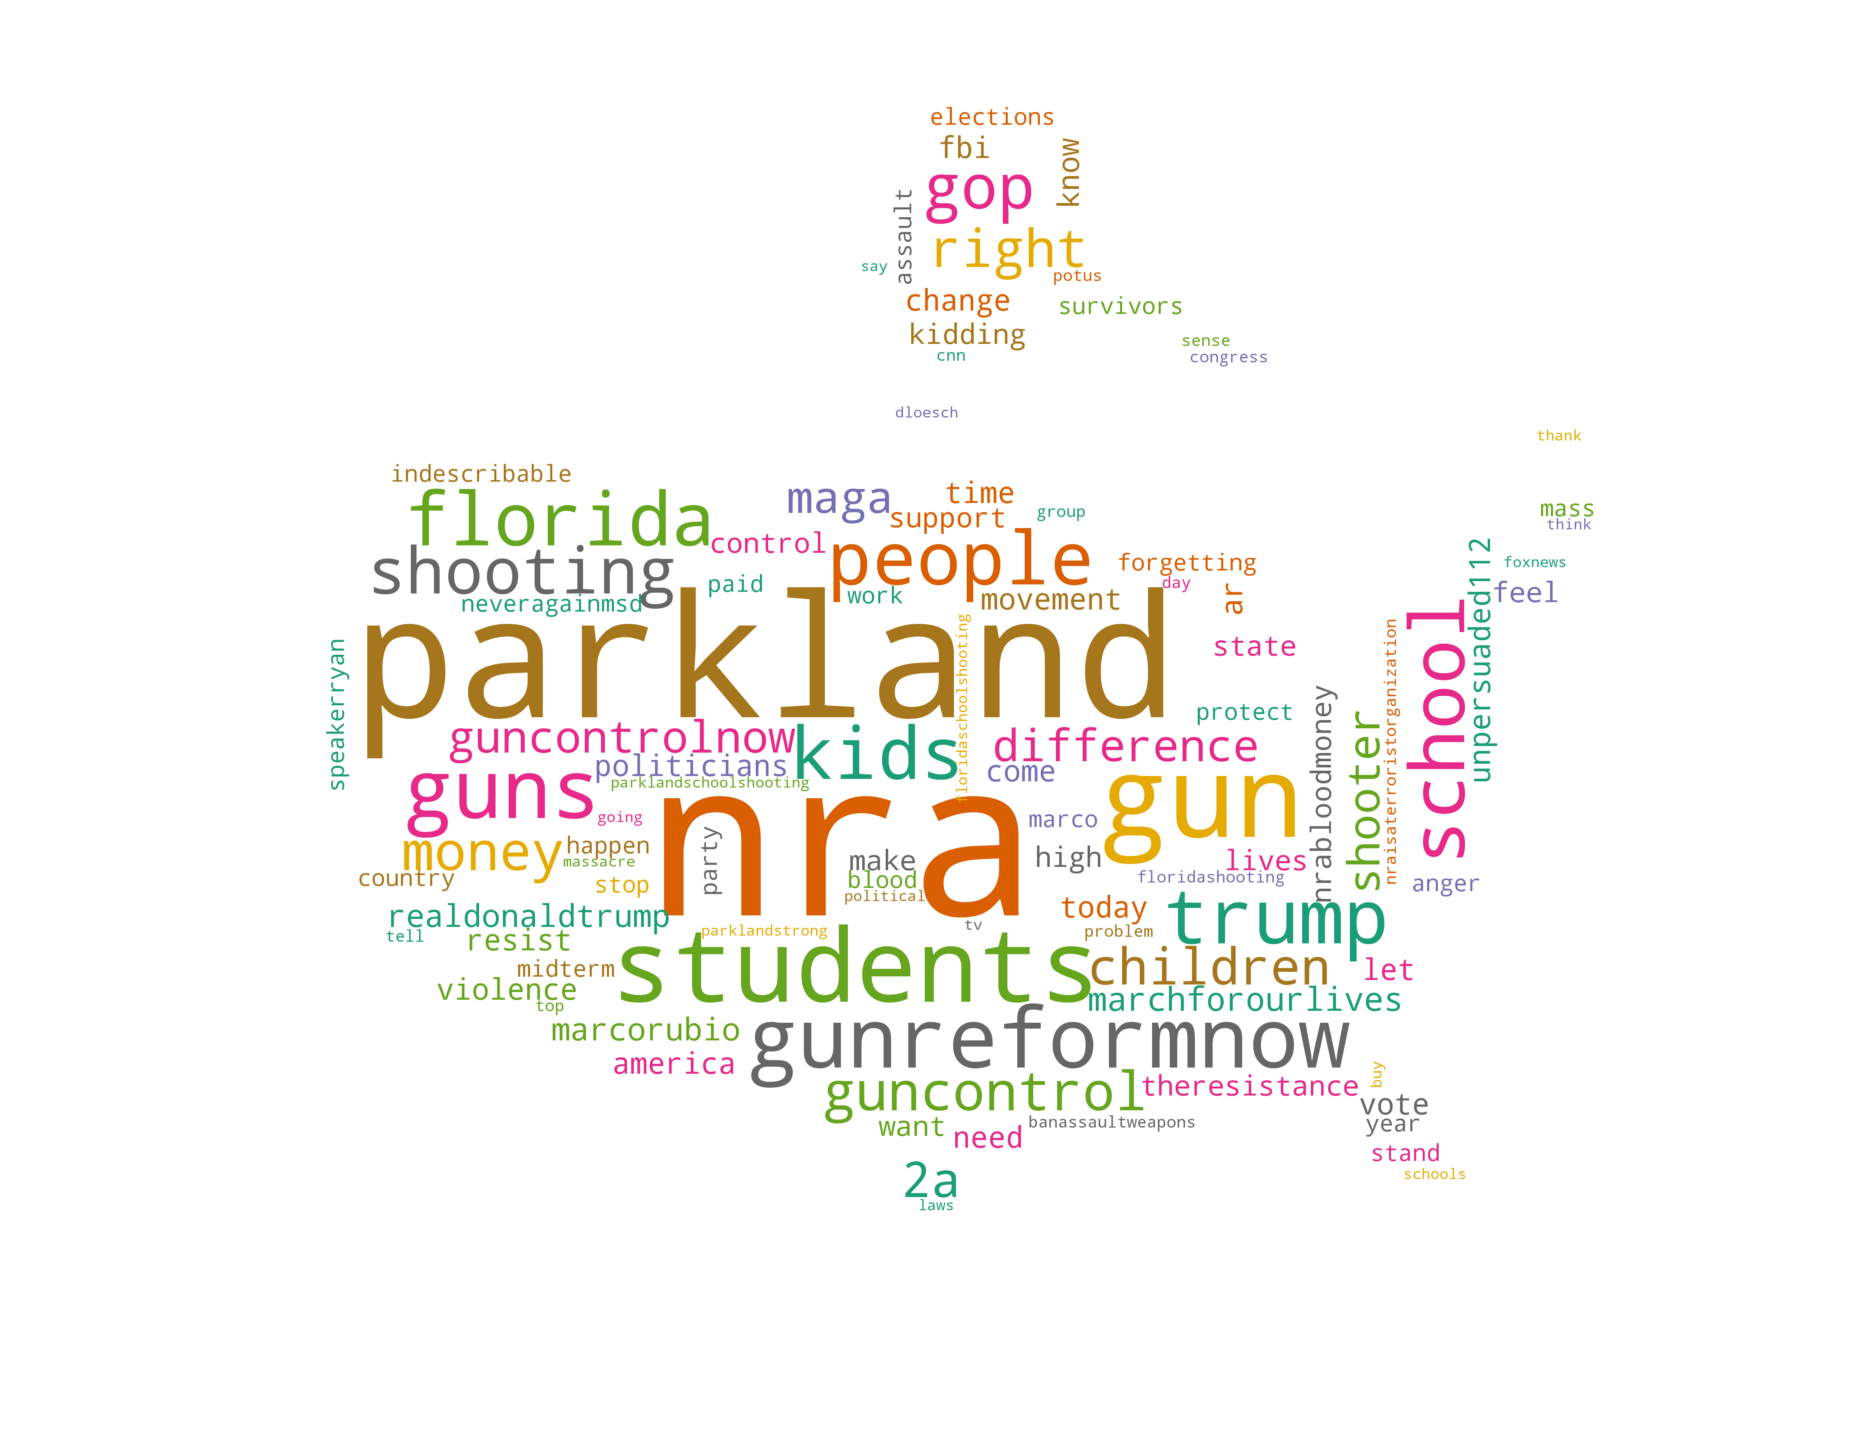

In [10]:
# Use case two, draw word cloud from a corpus root

textColIndex = 2

encoding = 'utf-8'

errors = 'ignore'

wcImgFilepath = '/N/u/klosteda/Carbonate/Text-Analysis/Output/wordcloudTwitterPolitical.png'

dpi = 300
# As an option, user can provision a mask related to the text theme
maskFilepath = '/N/u/klosteda/Carbonate/Text-Analysis/data/wordcloudMasks/USA.png'
maxWordCnt = 100

drawWordCloudFromScanCSV(csvRoot, textColIndex, encoding, errors, stopWordsList, wcImgFilepath, dpi, maxWordCnt, maskFilepath)